## An example recommendation system 
This notebook shows how you can create a simple recommender to identify similar questions in the Quora dataset. You can use this templace to create a recommender system which identifies similar customer support queries and then provides a saved reply which is associated with that question 

### Import the libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import random
import argparse
from sklearn.decomposition import PCA

### Import the Universal Sentence Encoder's TF Hub module

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)

### Set the relative paths

In [3]:
use_path = "dataset/"
quora_file = "quora_sample_clusters.csv"

### Create placeholder for the cosine similarity

In [4]:
# Use a TF placeholder
sts_input1 = tf.placeholder(tf.string, shape=(None))
sts_input2 = tf.placeholder(tf.string, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize(embed(sts_input1), axis=1)
sts_encode2 = tf.nn.l2_normalize(embed(sts_input2), axis=1)

# Get cosine similarity for comparison
cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
clip_cosine_similarities = tf.clip_by_value(cosine_similarities, 0.0, 1.0)
sim_scores = 1.0 - tf.divide(tf.acos(clip_cosine_similarities), 3.14)

### Get the Quora dataset

In [61]:
def get_quora_qs():
    quora_path = use_path + quora_file
    quora_qs = pd.read_csv(quora_path)
    return(quora_qs)
get_quora_qs()

,query,answer_group
0,I forgot my username and have no access to my ...,Missing Password
1,I made an account on my phone but I forgot the...,Missing Password
2,What are the steps for a password reset?,Missing Password
3,How do I recover my password when I'm not rece...,Missing Password
4,"If the ""retrieve password"" process for my acco...",Missing Password
5,Is there a way to insert multiple images?,Profile Image
6,How do I add an image?,Profile Image
7,Can I change my profile image?,Profile Image
8,Can I upload a image for users?,Profile Image
9,Whats the max size for a profile image?,Profile Image


### Get the cosine scores

In [6]:
def get_scores(session, questions):
    """Returns the similarity scores"""
    emba, embb, scores = session.run(
        [sts_encode1, sts_encode2, sim_scores],
        feed_dict={
            sts_input1: questions['new_query'].tolist(),
            sts_input2: questions['query'].tolist()
        })
    return (emba, embb, scores)

### Show a chart of cosine scores

In [7]:
def bar_scores(rec_df):
    objects = list(range(1, len(rec_df['query'].tolist()) +1))
    y_pos = np.arange(len(objects))
    performance = rec_df.index.values.tolist()
    plt.figure(figsize=(15,10))
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel(rec_df['new_query'].tolist()[0])
    plt.title('Top 5 Recommendations')
    loc = -0.1
    for i,res in enumerate(rec_df['query'].tolist()):
        plt.text(-0.7, loc, '{0}: {1}'.format(i+1, res), fontsize=15)
        loc-=0.1
    plt.show()

### Visualize the embeddings
We can use dimension reduction to represent the embeddings in a 2D scatter plot. This will enable us to see how close the sentence embeddings are physically. This is an alternative measure of similarity to the cosine similarity since it just measures similarity based on the embeddings only, i.e. not using any scoring method to compare them.

In [8]:
def pca_transform(recs):
    # Convert the 512 dimensions into 2 so we can represent them in a graph
    pca = PCA(2)  # project from 512 to 2 dimensions
    queries = recs['query'].tolist()
    queries.append(recs['new_query'].tolist()[0])
    
    embeds1 = recs['emba'].tolist()
    embeds2 = recs['embb'].tolist()
    embeds2.append(embeds1[0])
    projected = pca.fit_transform(embeds2)
    plt.figure(figsize=(15,10))
    # Create a DF of groups of lablels
    # Get the 2D embeds from each group of similar labels
    x,y =zip(*projected.tolist())
    plt.scatter(x,y)
    # Set a limit so there is some room for the points
    plt.xlim(-0.8, 0.8)
    plt.ylim(-0.8, 0.8)
    for (i, (x,y)) in enumerate(zip(x,y)):
        plt.text(x,y,queries[i], ha='center')
    plt.xlabel(recs['new_query'].tolist()[0])
    plt.ylabel(recs['new_query'].tolist()[0])
    plt.show()   

### Enter you sentence and the number of recommentions you would like to see
Add you test sentence here and then re-run the bottom two cells to see what is recommended

In [68]:
# This represents the new incoming query
new_query = "Do I need a credit card for a free trial"

# Set the number of top recommendations you would like to see
top_qs = 5

### Show the top results

In [69]:
with tf.Session() as session:
    qs_df = get_quora_qs()
    # Add new question column to DF
    qs_df["new_query"] = new_query 
    # Init the TF variables
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    # Get the similarity score
    emba, embb, scores = get_scores(session, qs_df)
    # Add the similarity scores to the DF
    qs_df['sim_score'] =  scores
    # Add the embeddings to the DF
    qs_df['emba'] = np.array(emba).tolist()
    qs_df['embb'] = np.array(embb).tolist()
    # Now sort them so we can get the top five closest matches
    sort_by_most_similar = qs_df.sort_values('sim_score', ascending=False)
    print('{:<10} {:<10} {:<20} {}'.format('Result', 'Score', 'Group', 'Matching Query'))
    for i, s in enumerate(sort_by_most_similar.round(4).head(n=top_qs).iterrows()):
        print('{:<10} {:<10.1f} {:<20} {}'.format(i+1, s[1][3]*100, s[1][1], s[1][0]))

Result     Score      Group                Matching Query
1          89.2       Credit Card Setup    Do I need a credit card to start a trial?
2          83.2       Credit Card Setup    Can I signup without a credit card?
3          82.7       Credit Card Setup    Do I need a credit cart to setup an account?
4          78.3       Credit Card Setup    How can I signup online without a credit card?
5          70.9       Update Account       Can I update my account?


### Show the charts and graphs

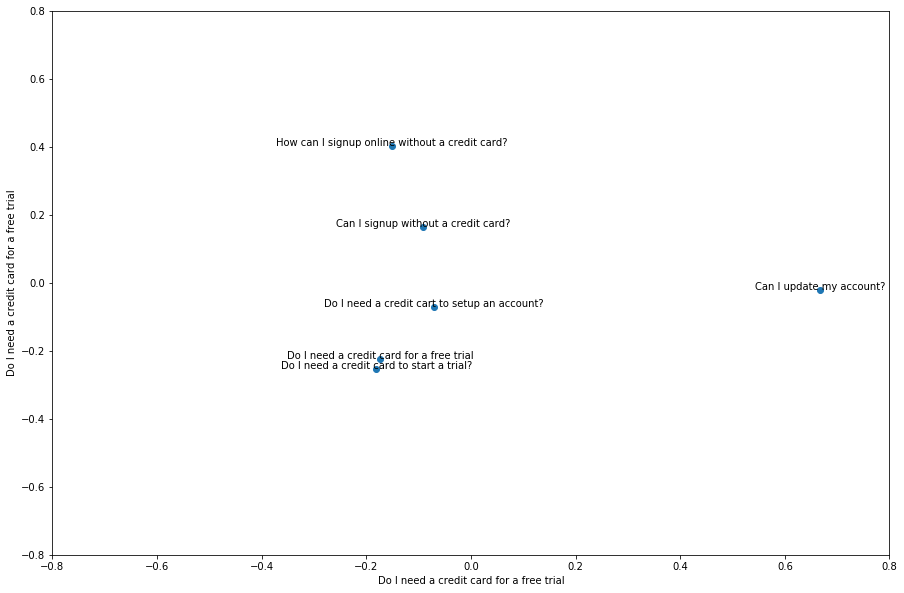

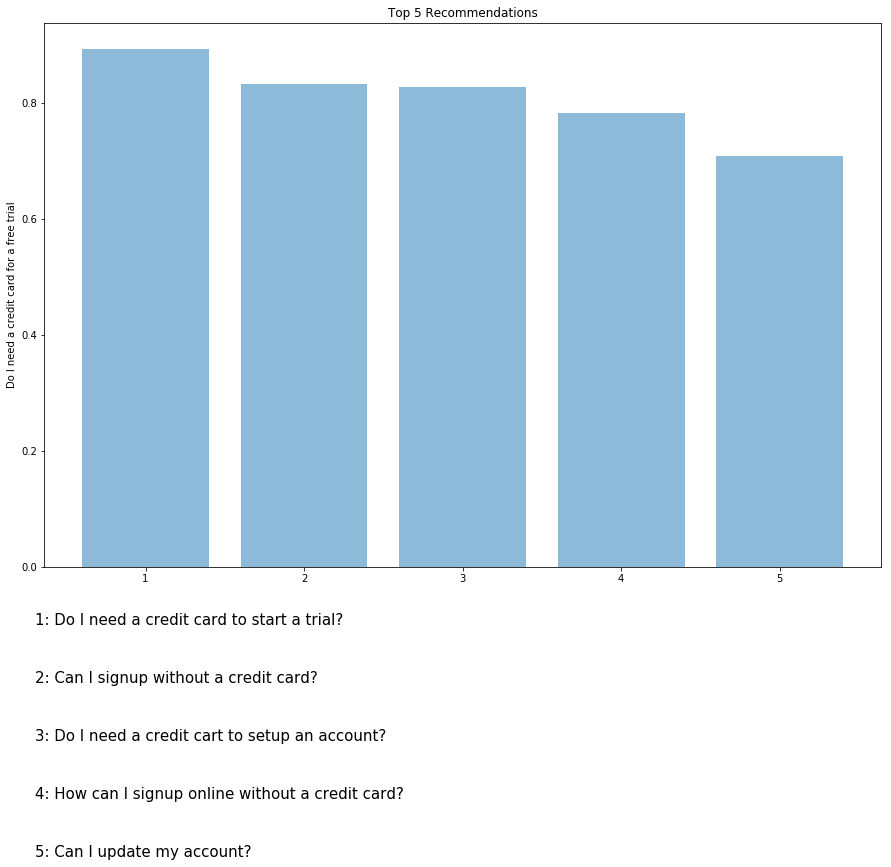

In [70]:
sort_by_most_similar = sort_by_most_similar.set_index('sim_score')
(sort_by_most_similar.head(n=top_qs)[['new_query', 'query', 
                                      'answer_group']]).to_csv('recommend.csv', float_format='%.4f')
pca_transform(sort_by_most_similar.head(n=top_qs))
bar_scores(sort_by_most_similar.head(n=top_qs))